<a href="https://colab.research.google.com/github/albionaguri/cybersecurity/blob/main/UBA_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generation

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)

n_entries = 10000
users = [f"user_{i}" for i in range(1, 6)]
actions = ['login', 'file_access', 'database_query', 'password_change', 'logout']
ip_addresses = ['192.168.1.', '10.0.0.', '172.16.0.']

data = []
start_time = datetime(2024, 7, 31, 8, 0, 0)  # Start at 8 AM

# Define normal behavior patterns for each user
user_patterns = {
    'user_1': {'login_time': 8, 'logout_time': 17, 'favorite_action': 'file_access'},
    'user_2': {'login_time': 9, 'logout_time': 18, 'favorite_action': 'database_query'},
    'user_3': {'login_time': 7, 'logout_time': 16, 'favorite_action': 'file_access'},
    'user_4': {'login_time': 10, 'logout_time': 19, 'favorite_action': 'database_query'},
    'user_5': {'login_time': 8, 'logout_time': 17, 'favorite_action': 'file_access'}
}

for i in range(n_entries):
    user = np.random.choice(users)
    pattern = user_patterns[user]

    # Time-based patterns
    hour = np.random.randint(pattern['login_time'], pattern['logout_time'])
    timestamp = start_time.replace(hour=hour, minute=np.random.randint(0, 60))

    # Action based on user's normal behavior
    if np.random.random() < 0.6:  # 60% chance of favorite action
        action = pattern['favorite_action']
    else:
        action = np.random.choice([a for a in actions if a != pattern['favorite_action']])

    ip_address = np.random.choice(ip_addresses) + str(np.random.randint(1, 255))

    # Normal ranges for duration and bytes
    if action == 'file_access':
        duration = np.random.randint(5, 60)
        bytes_transferred = np.random.randint(1000, 10000)
    elif action == 'database_query':
        duration = np.random.randint(1, 30)
        bytes_transferred = np.random.randint(100, 1000)
    else:
        duration = np.random.randint(1, 10)
        bytes_transferred = np.random.randint(10, 100)

    # Determine if the entry is an anomaly (3% chance)
    is_anomaly = np.random.random() < 0.03

    if is_anomaly:
        # Introduce more distinct anomalous behavior
        if action == 'login':
            ip_address = '203.0.113.' + str(np.random.randint(1, 255))  # Unknown IP
            hour = np.random.choice([h for h in range(24) if h < pattern['login_time'] - 1 or h > pattern['logout_time'] + 1])
        elif action == 'file_access':
            bytes_transferred = np.random.randint(50000, 100000)  # Unusually large file transfer
        elif action == 'database_query':
            duration = np.random.randint(100, 300)  # Unusually long query
        elif action == 'password_change':
            hour = np.random.randint(22, 24)  # Late night activity

    data.append({
        'timestamp': timestamp.replace(hour=hour),
        'user': user,
        'action': action,
        'ip_address': ip_address,
        'duration': duration,
        'bytes_transferred': bytes_transferred,
        'label': 'anomaly' if is_anomaly else 'normal'
    })

df = pd.DataFrame(data)
df = df.sort_values('timestamp')

print("\nSummary:")
print(f"Total entries: {len(df)}")
print(f"Normal entries: {len(df[df['label'] == 'normal'])}")
print(f"Anomaly entries: {len(df[df['label'] == 'anomaly'])}")


Summary:
Total entries: 10000
Normal entries: 9707
Anomaly entries: 293


In [2]:
df.head()

,timestamp,user,action,ip_address,duration,bytes_transferred,label
954,2024-07-31 00:18:00,user_5,login,203.0.113.125,6,71,anomaly
7737,2024-07-31 00:56:00,user_5,login,203.0.113.12,4,24,anomaly
6590,2024-07-31 01:00:00,user_2,login,203.0.113.204,6,68,anomaly
5806,2024-07-31 01:26:00,user_5,login,203.0.113.252,3,43,anomaly
6190,2024-07-31 01:36:00,user_2,login,203.0.113.99,3,20,anomaly


## EDA

In [3]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 2. Check for missing values
# print("\nMissing values:")
# print(df.isnull().sum())

# # 3. Distribution of actions
# plt.figure(figsize=(10, 6))
# df['action'].value_counts().plot(kind='bar')
# plt.title('Distribution of Actions')
# plt.xlabel('Action')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 4. Distribution of users
# plt.figure(figsize=(10, 6))
# df['user'].value_counts().plot(kind='bar')
# plt.title('Distribution of Users')
# plt.xlabel('User')
# plt.ylabel('Count')
# plt.tight_layout()
# plt.show()

# # 6. Scatter plot of duration vs bytes_transferred
# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=df, x='duration', y='bytes_transferred', hue='action', style='label')
# plt.title('Duration vs Bytes Transferred')
# plt.xlabel('Duration')
# plt.ylabel('Bytes Transferred')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# # 7. Box plot of duration by action
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=df, x='action', y='duration')
# plt.title('Duration by Action')
# plt.xlabel('Action')
# plt.ylabel('Duration')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


## Pre-process   

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [5]:
# Assuming we have already generated the DataFrame 'df' from the previous code

# 1. Prepare the data for clustering
# Select numerical features
features = ['duration', 'bytes_transferred']
X = df[features]

# Convert timestamp to hour and add it as a feature
X['hour'] = pd.to_datetime(df['timestamp']).dt.hour
X['hour'] = X['hour'].astype(float)

# Convert categorical variables to numerical
X['user'] = pd.Categorical(df['user']).codes
X['action'] = pd.Categorical(df['action']).codes
X['ip_subnet'] = df['ip_address'].apply(lambda x: x.split('.')[2]).astype(float)

# 2. Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<ipython-input-5-bce39cff1c38>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour'] = pd.to_datetime(df['timestamp']).dt.hour
<ipython-input-5-bce39cff1c38>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour'] = X['hour'].astype(float)
<ipython-input-5-bce39cff1c38>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

## K-means

In [6]:
# 3. Determine the optimal number of clusters using the elbow method
inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [7]:
silhouette_scores

[0.26386464318906366,
 0.25574889032162074,
 0.280093226106052,
 0.2632985143273098,
 0.25306069202415865,
 0.25709060520391697,
 0.2672383808681717,
 0.2619722414118478,
 0.26927375193421865]

In [8]:
df.head()

,timestamp,user,action,ip_address,duration,bytes_transferred,label
954,2024-07-31 00:18:00,user_5,login,203.0.113.125,6,71,anomaly
7737,2024-07-31 00:56:00,user_5,login,203.0.113.12,4,24,anomaly
6590,2024-07-31 01:00:00,user_2,login,203.0.113.204,6,68,anomaly
5806,2024-07-31 01:26:00,user_5,login,203.0.113.252,3,43,anomaly
6190,2024-07-31 01:36:00,user_2,login,203.0.113.99,3,20,anomaly


In [9]:
X.head()

,duration,bytes_transferred,hour,user,action,ip_subnet
954,6,71,0.0,4,2,113.0
7737,4,24,0.0,4,2,113.0
6590,6,68,1.0,1,2,113.0
5806,3,43,1.0,4,2,113.0
6190,3,20,1.0,1,2,113.0


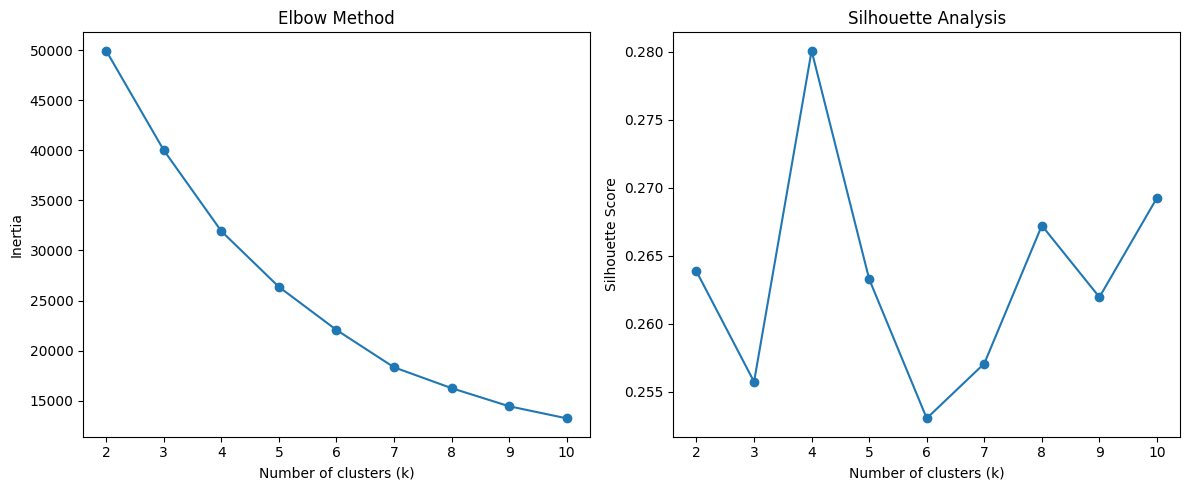

In [10]:

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [11]:
# 4. Choose the optimal number of clusters
optimal_k = 6

# 5. Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['km_cluster'] = kmeans.fit_predict(X_scaled)

# 6. Calculate distances to cluster centers
distances = kmeans.transform(X_scaled)
df['distance_to_center'] = distances.min(axis=1)

# 7. Define anomalies as points with distances greater than 2 standard deviations from the mean
threshold = df['distance_to_center'].mean() + 2 * df['distance_to_center'].std()
df['is_anomaly_km'] = df['distance_to_center'] > threshold

# 8. Compare clustering results with original labels
confusion_matrix = pd.crosstab(df['label'], df['is_anomaly_km'], rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:")
print(confusion_matrix)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Confusion Matrix:
Predicted  False  True 
Actual                 
anomaly      152    141
normal      9702      5


## PCA

In [12]:
# 2. Plot visualizing clusters, real anomalies, and detected anomalies
# Apply PCA for 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

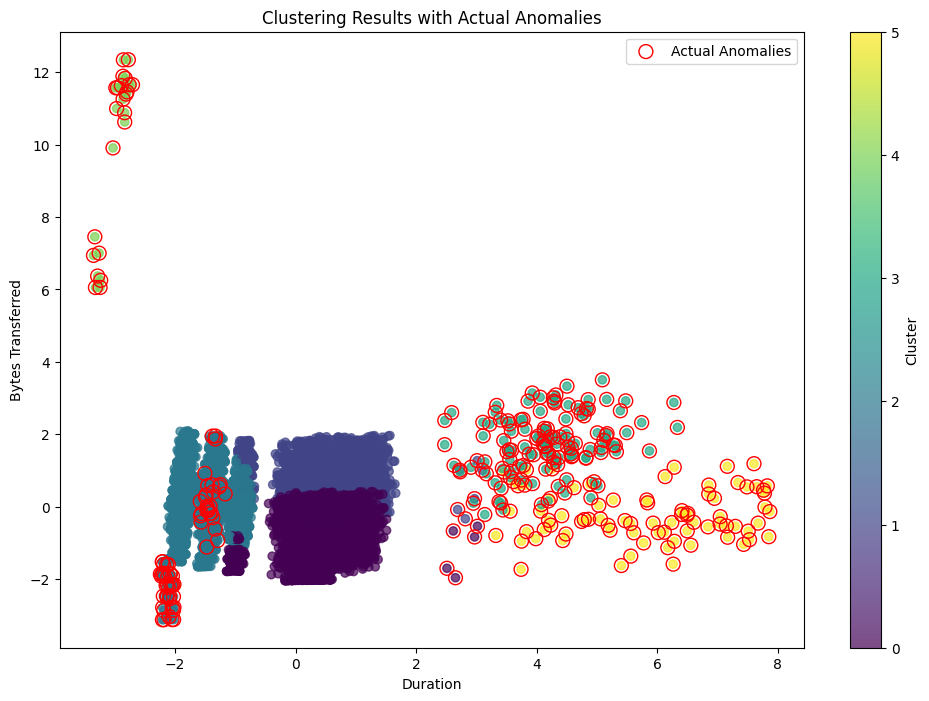

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot showing actual anomalies on quantitative variables
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['km_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.scatter(X_pca[df['label'] == 'anomaly', 0],
            X_pca[df['label'] == 'anomaly', 1],
            color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')
plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Clustering Results with Actual Anomalies')
plt.legend()
plt.show()





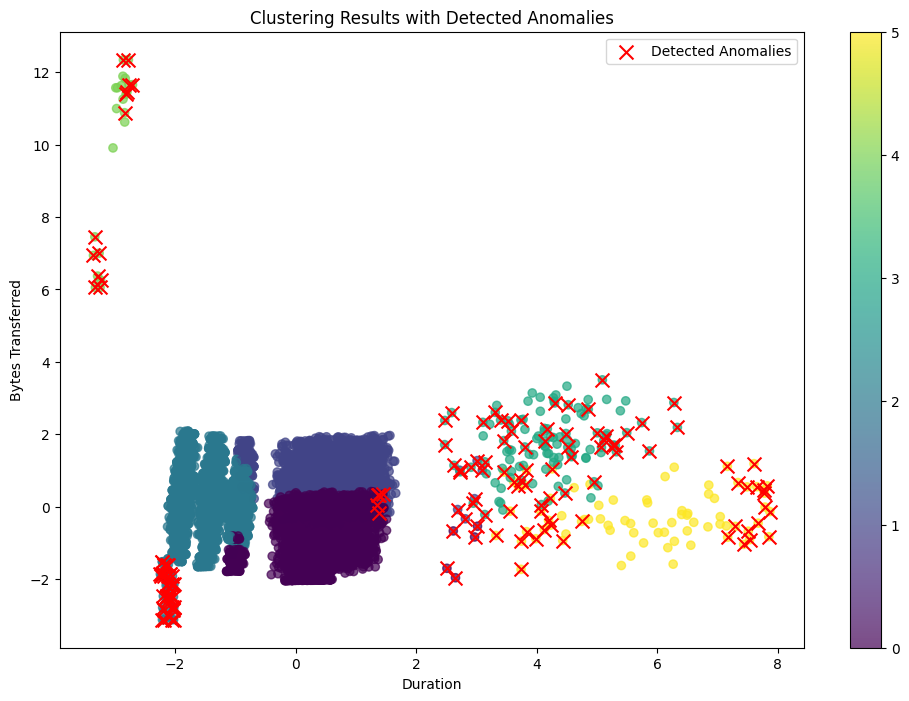

In [14]:
# 9. Visualize the results
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['cluster'], cmap='viridis', alpha=0.7)
# plt.colorbar(scatter)
# plt.scatter(X.loc[df['is_anomaly'], 'duration'], X.loc[df['is_anomaly'], 'bytes_transferred'],
#             color='red', marker='x', s=100, label='Detected Anomalies')
# plt.xlabel('Duration')
# plt.ylabel('Bytes Transferred')
# plt.title('Clustering Results with Detected Anomalies')
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['km_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)

plt.scatter(X_pca[df['is_anomaly_km'], 0], X_pca[df['is_anomaly_km'], 1],
            color='red', marker='x', s=100, label='Detected Anomalies')

plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Clustering Results with Detected Anomalies')
plt.legend()
plt.show()


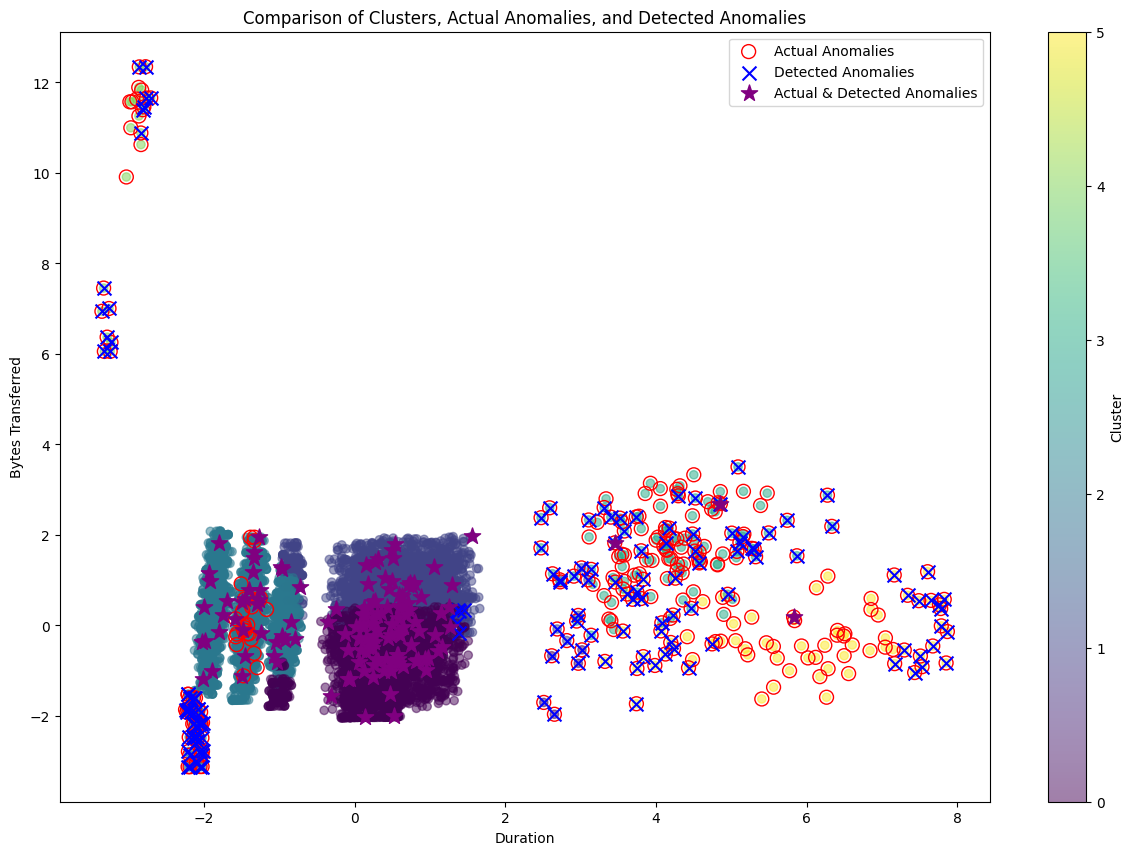

In [15]:
plt.figure(figsize=(15, 10))

# Plot all points
scatter = plt.scatter(X_pca[:, 0], X_pca[:,1], c=df['km_cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')

# Plot actual anomalies
plt.scatter(X_pca[df['label'] == 'anomaly', 0],  X_pca[df['label'] == 'anomaly', 1],
            color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')


# Plot detected anomalies
plt.scatter(X_pca[df['is_anomaly_km'], 0],
            X_pca[df['is_anomaly_km'], 1],
            color='blue', marker='x', s=100, label='Detected Anomalies')

# Highlight points that are both actual and detected anomalies
both_anomalies = df[(df['label'] == 'anomaly') & (df['is_anomaly_km'])]
plt.scatter(X_pca[both_anomalies.index, 0], X_pca[both_anomalies.index, 1],
            color='purple', marker='*', s=150, label='Actual & Detected Anomalies')

 # Highlight points that are both actual and detected anomalies
    # X_pca[both_anomalies.index, 2],


plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Comparison of Clusters, Actual Anomalies, and Detected Anomalies')
plt.legend()
plt.show()

In [16]:
# Calculate accuracy
accuracy = (confusion_matrix.loc['normal', False] + confusion_matrix.loc['anomaly', True]) / len(df)
print(f"\nAccuracy: {accuracy:.2f}")



Accuracy: 0.98


In [17]:
# 10. Print some example anomalies
print("\nExample Detected Anomalies:")
df[df['is_anomaly_km']].head()


Example Detected Anomalies:


,timestamp,user,action,ip_address,duration,bytes_transferred,label,km_cluster,distance_to_center,is_anomaly_km
954,2024-07-31 00:18:00,user_5,login,203.0.113.125,6,71,anomaly,4,3.372505,True
7737,2024-07-31 00:56:00,user_5,login,203.0.113.12,4,24,anomaly,4,3.372201,True
6590,2024-07-31 01:00:00,user_2,login,203.0.113.204,6,68,anomaly,4,2.866697,True
5806,2024-07-31 01:26:00,user_5,login,203.0.113.252,3,43,anomaly,4,3.054157,True
6190,2024-07-31 01:36:00,user_2,login,203.0.113.99,3,20,anomaly,4,2.867041,True


In [18]:
df.columns

Index(['timestamp', 'user', 'action', 'ip_address', 'duration',
       'bytes_transferred', 'label', 'km_cluster', 'distance_to_center',
       'is_anomaly_km'],
      dtype='object')

In [19]:
# 3. Print summary statistics
print("\nSummary Statistics:")
print(f"Total entries: {len(df)}")
print(f"Actual anomalies: {len(df[df['label'] == 'anomaly'])}")
print(f"Detected anomalies: {len(df[df['is_anomaly_km']])}")
print(f"Correctly identified anomalies: {len(both_anomalies)}")


Summary Statistics:
Total entries: 10000
Actual anomalies: 293
Detected anomalies: 146
Correctly identified anomalies: 141


In [20]:
# 4. Calculate and print precision, recall, and F1-score
true_positives = len(both_anomalies)
false_positives = len(df[df['is_anomaly_km']]) - true_positives
false_negatives = len(df[df['label'] == 'anomaly']) - true_positives

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nPerformance Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")


Performance Metrics:
Precision: 0.97
Recall: 0.48
F1-score: 0.64


In [21]:
X.head()

,duration,bytes_transferred,hour,user,action,ip_subnet
954,6,71,0.0,4,2,113.0
7737,4,24,0.0,4,2,113.0
6590,6,68,1.0,1,2,113.0
5806,3,43,1.0,4,2,113.0
6190,3,20,1.0,1,2,113.0


## DBSCAN

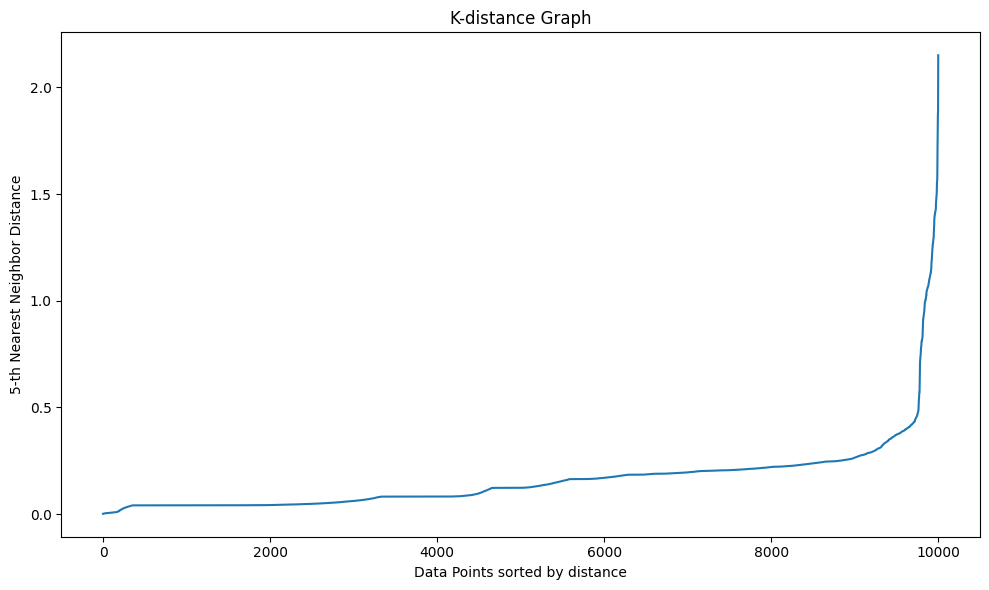

In [22]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Determine optimal epsilon using k-distance graph
k = 5  # number of neighbors
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort and plot k-distance graph
distances = np.sort(distances[:, k-1])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.tight_layout()
plt.show()

In [23]:
# Choose epsilon based on the "elbow" in the k-distance graph
epsilon =  0.4  # You should adjust this value based on the k-distance graph

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=k)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Identify anomalies (points labeled as noise by DBSCAN)
df['is_anomaly_dbscan'] = df['dbscan_cluster'] == -1

In [24]:
# Compare DBSCAN results with original labels
confusion_matrix = pd.crosstab(df['label'], df['is_anomaly_dbscan'], rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:")
print(confusion_matrix)




Confusion Matrix:
Predicted  False  True 
Actual                 
anomaly       65    228
normal      9672     35


In [25]:
# Calculate accuracy
accuracy = (confusion_matrix.loc['normal', False] + confusion_matrix.loc['anomaly', True]) / len(df)
print(f"\nAccuracy: {accuracy:.2f}")




Accuracy: 0.99


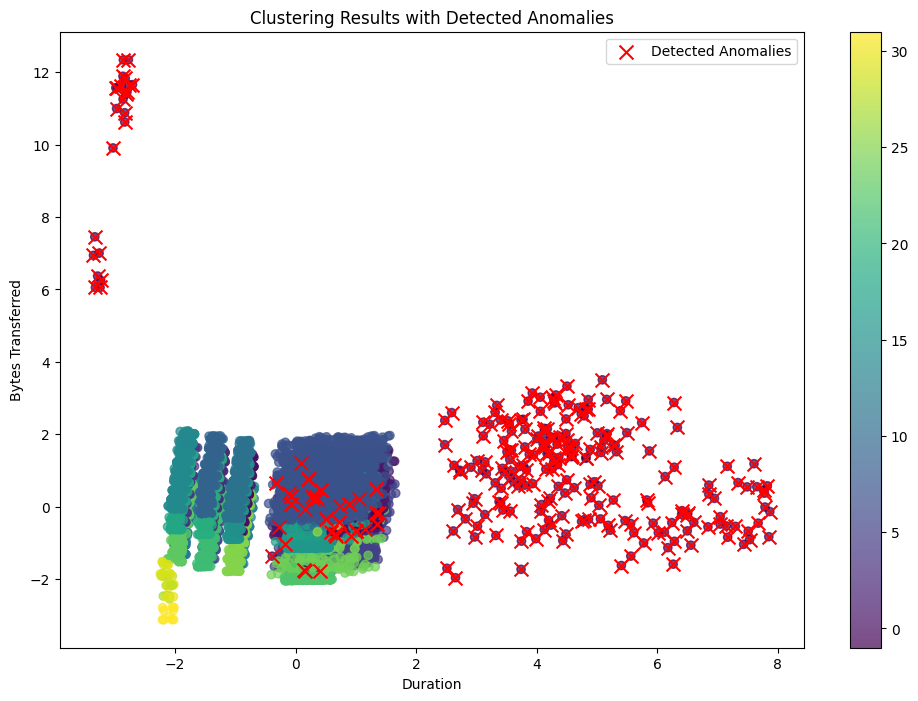

In [26]:
# # Visualize the results
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['cluster'], cmap='viridis', alpha=0.7)
# plt.colorbar(scatter)
# plt.scatter(X.loc[df['is_anomaly'], 'duration'], X.loc[df['is_anomaly'], 'bytes_transferred'],
#             color='red', marker='x', s=100, label='Detected Anomalies')
# plt.xlabel('Duration')
# plt.ylabel('Bytes Transferred')
# plt.title('DBSCAN Clustering Results with Detected Anomalies')
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['dbscan_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)

plt.scatter(X_pca[df['is_anomaly_dbscan'], 0], X_pca[df['is_anomaly_dbscan'], 1],
            color='red', marker='x', s=100, label='Detected Anomalies')

plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Clustering Results with Detected Anomalies')
plt.legend()
plt.show()

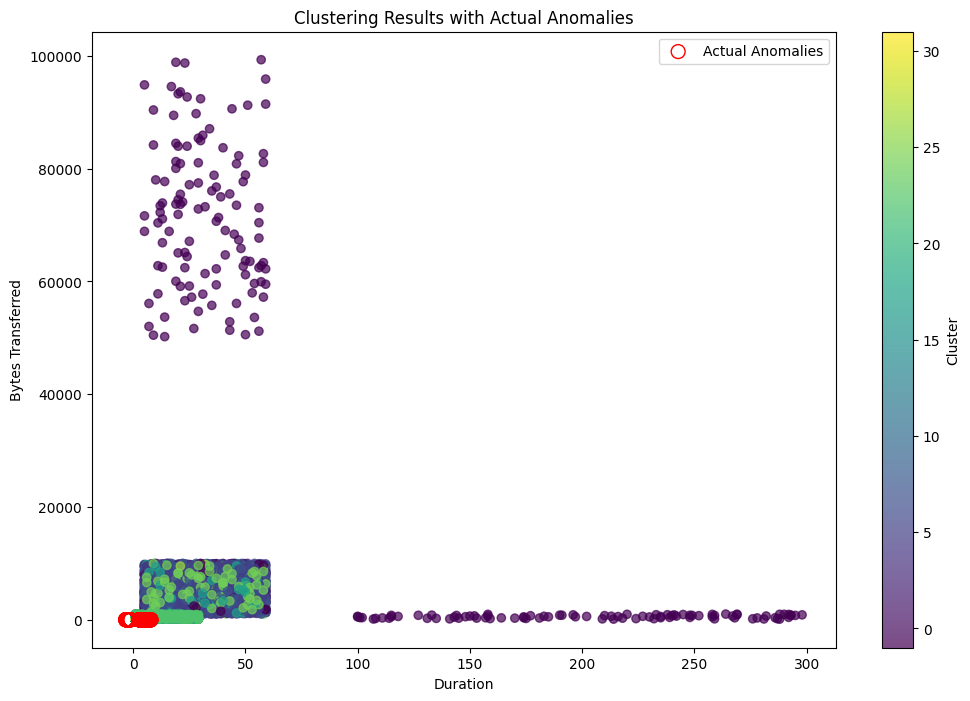

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot showing actual anomalies on quantitative variables
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['cluster'], cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='Cluster')
# plt.scatter(X.loc[df['label'] == 'anomaly', 'duration'],
#             X.loc[df['label'] == 'anomaly', 'bytes_transferred'],
#             color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')
# plt.xlabel('Duration')
# plt.ylabel('Bytes Transferred')
# plt.title('Clustering Results with Actual Anomalies')
# plt.legend()
# plt.show()


# 1. Plot showing actual anomalies on quantitative variables
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['dbscan_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.scatter(X_pca[df['label'] == 'anomaly', 0],
            X_pca[df['label'] == 'anomaly', 1],
            color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')
plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Clustering Results with Actual Anomalies')
plt.legend()
plt.show()





In [28]:
# Print some example anomalies
print("\nExample Detected Anomalies:")
df[df['is_anomaly_dbscan']]


Example Detected Anomalies:


,timestamp,user,action,ip_address,duration,bytes_transferred,label,km_cluster,distance_to_center,is_anomaly_km,dbscan_cluster,is_anomaly_dbscan
954,2024-07-31 00:18:00,user_5,login,203.0.113.125,6,71,anomaly,4,3.372505,True,-1,True
7737,2024-07-31 00:56:00,user_5,login,203.0.113.12,4,24,anomaly,4,3.372201,True,-1,True
6590,2024-07-31 01:00:00,user_2,login,203.0.113.204,6,68,anomaly,4,2.866697,True,-1,True
5806,2024-07-31 01:26:00,user_5,login,203.0.113.252,3,43,anomaly,4,3.054157,True,-1,True
6190,2024-07-31 01:36:00,user_2,login,203.0.113.99,3,20,anomaly,4,2.867041,True,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8957,2024-07-31 22:12:00,user_2,login,203.0.113.252,4,55,anomaly,4,4.661747,True,-1,True
1046,2024-07-31 23:13:00,user_3,login,203.0.113.126,7,40,anomaly,4,4.944197,True,-1,True
395,2024-07-31 23:23:00,user_1,login,203.0.113.101,9,46,anomaly,4,5.169784,True,-1,True
7116,2024-07-31 23:37:00,user_4,login,203.0.113.162,5,88,anomaly,4,4.980529,True,-1,True


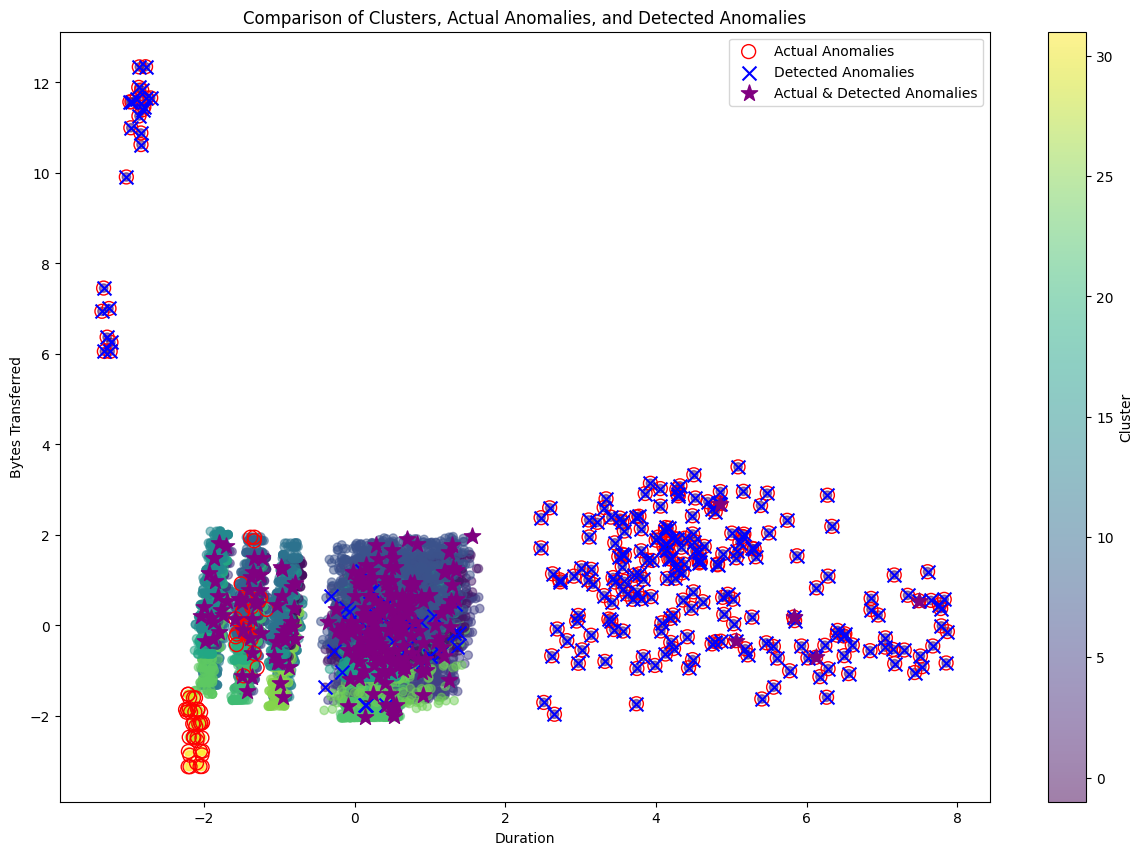

In [29]:
plt.figure(figsize=(15, 10))

# Plot all points
scatter = plt.scatter(X_pca[:, 0], X_pca[:,1], c=df['dbscan_cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')

# Plot actual anomalies
plt.scatter(X_pca[df['label'] == 'anomaly', 0],  X_pca[df['label'] == 'anomaly', 1],
            color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')


# Plot detected anomalies
plt.scatter(X_pca[df['is_anomaly_dbscan'], 0],
            X_pca[df['is_anomaly_dbscan'], 1],
            color='blue', marker='x', s=100, label='Detected Anomalies')

# Highlight points that are both actual and detected anomalies
both_anomalies = df[(df['label'] == 'anomaly') & (df['is_anomaly_dbscan'])]
plt.scatter(X_pca[both_anomalies.index, 0], X_pca[both_anomalies.index, 1],
            color='purple', marker='*', s=150, label='Actual & Detected Anomalies')

 # Highlight points that are both actual and detected anomalies
    # X_pca[both_anomalies.index, 2],


plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Comparison of Clusters, Actual Anomalies, and Detected Anomalies')
plt.legend()
plt.show()

In [30]:
df.columns

Index(['timestamp', 'user', 'action', 'ip_address', 'duration',
       'bytes_transferred', 'label', 'km_cluster', 'distance_to_center',
       'is_anomaly_km', 'dbscan_cluster', 'is_anomaly_dbscan'],
      dtype='object')

In [32]:
# 3. Print summary statistics
print("\nSummary Statistics:")
print(f"Total entries: {len(df)}")
print(f"Actual anomalies: {len(df[df['label'] == 'anomaly'])}")
print(f"Detected anomalies: {len(df[df['is_anomaly_dbscan']])}")
print(f"Correctly identified anomalies: {len(both_anomalies)}")




Summary Statistics:
Total entries: 10000
Actual anomalies: 293
Detected anomalies: 263
Correctly identified anomalies: 228


In [33]:
# 4. Calculate and print precision, recall, and F1-score
true_positives = len(both_anomalies)
false_positives = len(df[df['is_anomaly_dbscan']]) - true_positives
false_negatives = len(df[df['label'] == 'anomaly']) - true_positives

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nPerformance Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")


Performance Metrics:
Precision: 0.87
Recall: 0.78
F1-score: 0.82


## ISOLATION FOREST

In [34]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)

df['iso_cluster'] = iso_forest.fit_predict(X_scaled)
df['is_anomaly_isolation_forest'] = df['iso_cluster'] == -1



In [35]:
df["iso_cluster"].nunique()

2

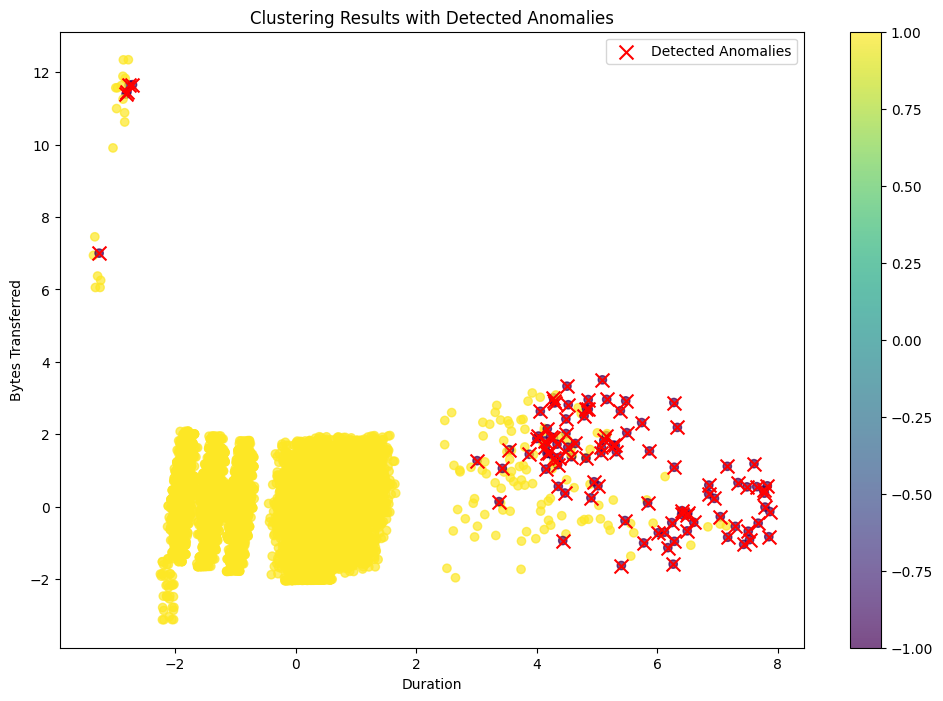

In [36]:
# Visualize the results
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['cluster'], cmap='viridis', alpha=0.7)
# plt.colorbar(scatter)
# plt.scatter(X.loc[df['is_anomaly'], 'duration'], X.loc[df['is_anomaly'], 'bytes_transferred'],
#             color='red', marker='x', s=100, label='Detected Anomalies')
# plt.xlabel('Duration')
# plt.ylabel('Bytes Transferred')
# plt.title('Isolation forest Results with Detected Anomalies')
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['iso_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)

plt.scatter(X_pca[df['is_anomaly_isolation_forest'], 0], X_pca[df['is_anomaly_isolation_forest'], 1],
            color='red', marker='x', s=100, label='Detected Anomalies')

plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Clustering Results with Detected Anomalies')
plt.legend()
plt.show()






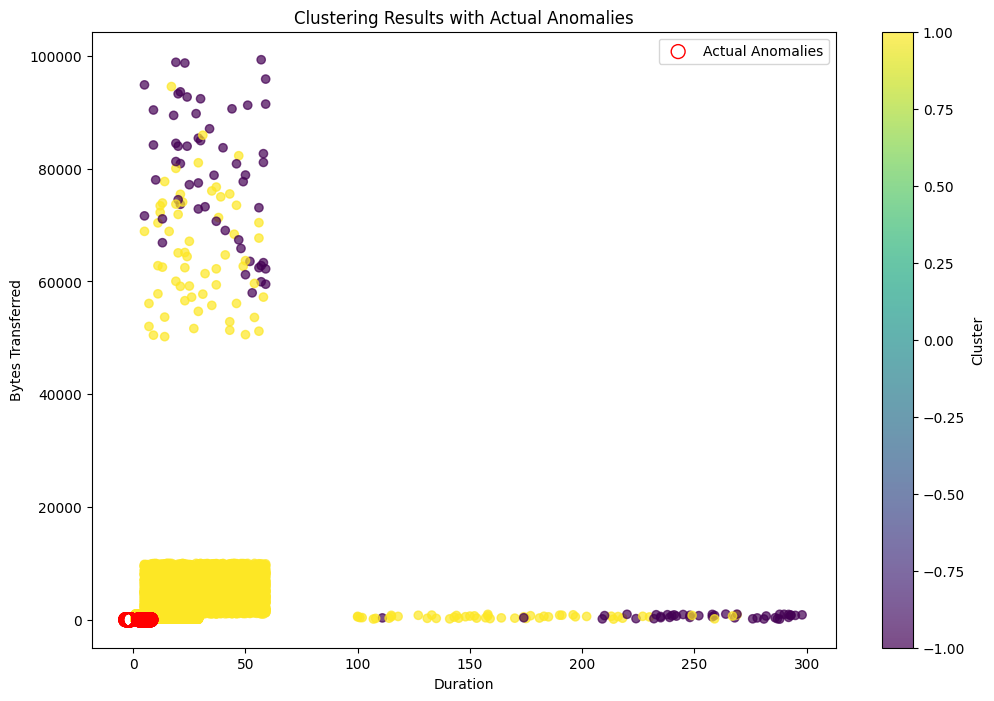

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# # 1. Plot showing actual anomalies on quantitative variables
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['cluster'], cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='Cluster')
# plt.scatter(X.loc[df['label'] == 'anomaly', 'duration'],
#             X.loc[df['label'] == 'anomaly', 'bytes_transferred'],
#             color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')
# plt.xlabel('Duration')
# plt.ylabel('Bytes Transferred')
# plt.title('Isolation Forest Results with Actual Anomalies')
# plt.legend()
# plt.show()



import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot showing actual anomalies on quantitative variables
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X['duration'], X['bytes_transferred'], c=df['iso_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.scatter(X_pca[df['label'] == 'anomaly', 0],
            X_pca[df['label'] == 'anomaly', 1],
            color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')
plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Clustering Results with Actual Anomalies')
plt.legend()
plt.show()





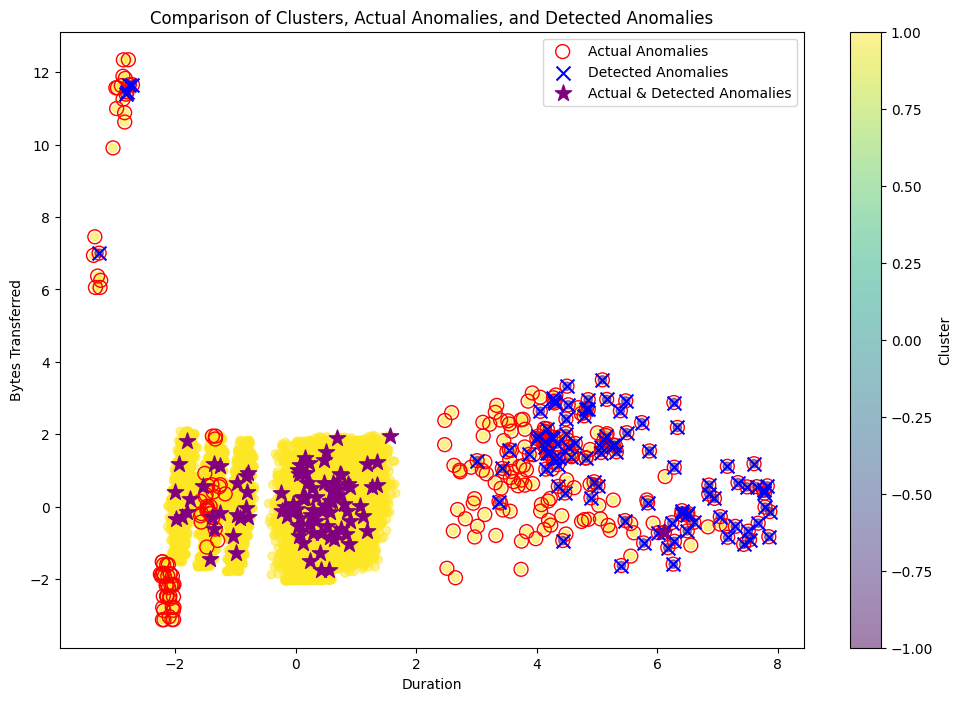

In [41]:
# Plot all points
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:,1], c=df['iso_cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')

# Plot actual anomalies
plt.scatter(X_pca[df['label'] == 'anomaly', 0],  X_pca[df['label'] == 'anomaly', 1],
            color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')


# Plot detected anomalies
plt.scatter(X_pca[df['is_anomaly_isolation_forest'], 0],
            X_pca[df['is_anomaly_isolation_forest'], 1],
            color='blue', marker='x', s=100, label='Detected Anomalies')

# Highlight points that are both actual and detected anomalies
both_anomalies = df[(df['label'] == 'anomaly') & (df['is_anomaly_isolation_forest'])]
plt.scatter(X_pca[both_anomalies.index, 0], X_pca[both_anomalies.index, 1],
            color='purple', marker='*', s=150, label='Actual & Detected Anomalies')

 # Highlight points that are both actual and detected anomalies
    # X_pca[both_anomalies.index, 2],


plt.xlabel('Duration')
plt.ylabel('Bytes Transferred')
plt.title('Comparison of Clusters, Actual Anomalies, and Detected Anomalies')
plt.legend()
plt.show()

In [42]:
# Compare Isolation Forest results with original labels
confusion_matrix = pd.crosstab(df['label'], df['is_anomaly_isolation_forest'], rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:")
print(confusion_matrix)



Confusion Matrix:
Predicted  False  True 
Actual                 
anomaly      193    100
normal      9707      0


In [43]:
# Calculate accuracy
accuracy = (confusion_matrix.loc['normal', False] + confusion_matrix.loc['anomaly', True]) / len(df)
print(f"\nAccuracy: {accuracy:.2f}")



Accuracy: 0.98


In [44]:
# 3. Print summary statistics
print("\nSummary Statistics:")
print(f"Total entries: {len(df)}")
print(f"Actual anomalies: {len(df[df['label'] == 'anomaly'])}")
print(f"Detected anomalies: {len(df[df['is_anomaly_isolation_forest']])}")
print(f"Correctly identified anomalies: {len(both_anomalies)}")


Summary Statistics:
Total entries: 10000
Actual anomalies: 293
Detected anomalies: 100
Correctly identified anomalies: 100


In [45]:
#Calculate and print precision, recall, and F1-score
true_positives = len(both_anomalies)
false_positives = len(df[df['is_anomaly_isolation_forest']]) - true_positives
false_negatives = len(df[df['label'] == 'anomaly']) - true_positives

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nPerformance Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")


Performance Metrics:
Precision: 1.00
Recall: 0.34
F1-score: 0.51


In [47]:
# Print some example anomalies
print("\nExample Detected Anomalies:")
df[df['is_anomaly_isolation_forest']]


Example Detected Anomalies:


,timestamp,user,action,ip_address,duration,bytes_transferred,label,km_cluster,distance_to_center,is_anomaly_km,dbscan_cluster,is_anomaly_dbscan,iso_cluster,is_anomaly_isolation_forest
954,2024-07-31 00:18:00,user_5,login,203.0.113.125,6,71,anomaly,4,3.372505,True,-1,True,-1,True
7737,2024-07-31 00:56:00,user_5,login,203.0.113.12,4,24,anomaly,4,3.372201,True,-1,True,-1,True
5806,2024-07-31 01:26:00,user_5,login,203.0.113.252,3,43,anomaly,4,3.054157,True,-1,True,-1,True
3432,2024-07-31 02:39:00,user_4,login,203.0.113.168,5,77,anomaly,4,2.480194,True,-1,True,-1,True
5501,2024-07-31 07:23:00,user_3,file_access,192.168.1.88,21,80915,anomaly,3,2.180458,False,-1,True,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,2024-07-31 17:15:00,user_2,database_query,10.0.0.26,242,642,anomaly,5,1.803411,False,-1,True,-1,True
5734,2024-07-31 17:21:00,user_2,database_query,192.168.1.54,174,345,anomaly,5,2.441558,True,-1,True,-1,True
438,2024-07-31 17:38:00,user_4,database_query,172.16.0.111,209,146,anomaly,5,1.649347,False,-1,True,-1,True
3689,2024-07-31 17:40:00,user_2,database_query,10.0.0.32,288,960,anomaly,5,3.201312,True,-1,True,-1,True
